In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import LeakyReLU, PReLU, Dropout
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from keras import regularizers

Using TensorFlow backend.


# load data

In [2]:
cab_df = pd.read_csv("cab_rides.csv",delimiter='\t',encoding = "utf-16")
weather_df = pd.read_csv("weather.csv",delimiter='\t',encoding = "utf-16")

# preprocess data

In [3]:
cab_df['date_time'] = pd.to_datetime(cab_df['time_stamp']/1000, unit='s')
weather_df['date_time'] = pd.to_datetime(weather_df['time_stamp'], unit='s')
cab_df['merge_date'] = cab_df.source.astype(str) +" - "+ cab_df.date_time.dt.date.astype("str") +" - "+ cab_df.date_time.dt.hour.astype("str")
weather_df['merge_date'] = weather_df.location.astype(str) +" - "+ weather_df.date_time.dt.date.astype("str") +" - "+ weather_df.date_time.dt.hour.astype("str")
weather_df.index = weather_df['merge_date']
merged_df = cab_df.join(weather_df,on=['merge_date'],rsuffix ='_w')
merged_df['rain'].fillna(0,inplace=True)
merged_df = merged_df[pd.notnull(merged_df['date_time_w'])]
merged_df = merged_df[pd.notnull(merged_df['price'])]
merged_df['day'] = merged_df.date_time.dt.dayofweek
merged_df['hour'] = merged_df.date_time.dt.hour
merged_df.columns
merged_df.count()
x = merged_df[merged_df.product_id=='lyft_line'][['day','distance','hour','temp','clouds', 'pressure','humidity', 'wind', 'rain']]
x.count()
y = merged_df[merged_df.product_id=='lyft_line']['price']
y.count()
x.reset_index(inplace=True)
x = x.drop(columns=['index'])
sc = StandardScaler()
x = sc.fit_transform(x)
y = np.array(y)

# split data into training and testing sets

In [4]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.1, random_state = 0)

# Our model

In [5]:
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras import Sequential
model = Sequential()
model.add(Conv1D(256, kernel_size = 8,padding='same',activation='relu',strides=1, input_shape=(9,1)))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(128, kernel_size = 4,padding='same',activation='relu',strides=1))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(128, kernel_size = 4,padding='same',activation='relu',strides=1))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(64, kernel_size = 2,padding='same',activation='relu',strides=1))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size = 2,padding='same',activation='relu',strides=1))
model.add(MaxPooling1D((2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size = 2,padding='same',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 9, 256)            2304      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 256)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            131200    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 128)           

# Train

In [6]:
sgd = optimizers.SGD(lr=0.01, momentum=0.1, clipnorm=1.)
model.compile(optimizer = sgd,
              loss = 'mae',
              metrics=['mape'])
history = model.fit(train_x.reshape(len(train_x),9,1), train_y,
          batch_size=128,
          epochs=1000,
          validation_data = (test_x.reshape(len(test_x),9,1), test_y))

Train on 81936 samples, validate on 9105 samples
Epoch 1/1000
81936/81936 [==============================] - 9s 115us/step - loss: 2.4190 - mape: 44.1225 - val_loss: 1.6954 - val_mape: 34.0490
Epoch 2/1000
81936/81936 [==============================] - 9s 110us/step - loss: 1.4915 - mape: 29.0889 - val_loss: 0.9572 - val_mape: 19.0238
Epoch 3/1000
81936/81936 [==============================] - 9s 110us/step - loss: 1.2588 - mape: 23.4241 - val_loss: 0.9079 - val_mape: 17.1469
Epoch 4/1000
81936/81936 [==============================] - 9s 109us/step - loss: 1.1872 - mape: 21.6235 - val_loss: 0.8692 - val_mape: 15.6883
Epoch 5/1000
81936/81936 [==============================] - 9s 111us/step - loss: 1.1454 - mape: 20.7380 - val_loss: 0.8462 - val_mape: 15.1638
Epoch 6/1000
81936/81936 [==============================] - 9s 109us/step - loss: 1.1058 - mape: 19.9955 - val_loss: 0.8095 - val_mape: 14.5631
Epoch 7/1000
81936/81936 [==============================] - 9s 109us/step - loss: 1.074

81936/81936 [==============================] - 9s 104us/step - loss: 0.7264 - mape: 13.0612 - val_loss: 0.6464 - val_mape: 11.8650
Epoch 114/1000
81936/81936 [==============================] - 8s 104us/step - loss: 0.7224 - mape: 12.9169 - val_loss: 0.6162 - val_mape: 11.4491
Epoch 115/1000
81936/81936 [==============================] - 8s 104us/step - loss: 0.7241 - mape: 12.8736 - val_loss: 0.6227 - val_mape: 11.4123
Epoch 116/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.7238 - mape: 12.9711 - val_loss: 0.6282 - val_mape: 11.6547
Epoch 117/1000
81936/81936 [==============================] - 9s 105us/step - loss: 0.7244 - mape: 12.9807 - val_loss: 0.6364 - val_mape: 11.5493
Epoch 118/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.7204 - mape: 12.8106 - val_loss: 0.6248 - val_mape: 11.4976
Epoch 119/1000
81936/81936 [==============================] - 9s 105us/step - loss: 0.7201 - mape: 12.9247 - val_loss: 0.6256 - val_mape: 1

81936/81936 [==============================] - 8s 102us/step - loss: 0.6931 - mape: 12.4130 - val_loss: 0.6239 - val_mape: 11.4330
Epoch 226/1000
81936/81936 [==============================] - 8s 103us/step - loss: 0.6958 - mape: 12.4972 - val_loss: 0.6087 - val_mape: 11.0911
Epoch 227/1000
81936/81936 [==============================] - 8s 103us/step - loss: 0.6953 - mape: 12.3755 - val_loss: 0.6426 - val_mape: 11.6436
Epoch 228/1000
81936/81936 [==============================] - 8s 103us/step - loss: 0.6926 - mape: 12.4222 - val_loss: 0.6070 - val_mape: 11.2917
Epoch 229/1000
81936/81936 [==============================] - 8s 103us/step - loss: 0.6957 - mape: 12.5006 - val_loss: 0.6146 - val_mape: 11.2819
Epoch 230/1000
81936/81936 [==============================] - 8s 103us/step - loss: 0.6911 - mape: 12.3720 - val_loss: 0.6273 - val_mape: 11.4208
Epoch 231/1000
81936/81936 [==============================] - 8s 103us/step - loss: 0.6931 - mape: 12.4310 - val_loss: 0.6250 - val_mape: 1

81936/81936 [==============================] - 9s 104us/step - loss: 0.6758 - mape: 12.2328 - val_loss: 0.6012 - val_mape: 10.9745
Epoch 338/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6741 - mape: 12.1843 - val_loss: 0.6033 - val_mape: 11.1570
Epoch 339/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6741 - mape: 12.1821 - val_loss: 0.6125 - val_mape: 11.1301
Epoch 340/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6739 - mape: 12.2102 - val_loss: 0.5983 - val_mape: 10.9074
Epoch 341/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6753 - mape: 12.1672 - val_loss: 0.5897 - val_mape: 10.7998
Epoch 342/1000
81936/81936 [==============================] - 9s 105us/step - loss: 0.6735 - mape: 12.1649 - val_loss: 0.5927 - val_mape: 11.1358
Epoch 343/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6711 - mape: 12.1590 - val_loss: 0.5973 - val_mape: 1

81936/81936 [==============================] - 8s 102us/step - loss: 0.6554 - mape: 11.9860 - val_loss: 0.5968 - val_mape: 11.1770
Epoch 450/1000
81936/81936 [==============================] - 8s 102us/step - loss: 0.6583 - mape: 12.0865 - val_loss: 0.6025 - val_mape: 11.0172
Epoch 451/1000
81936/81936 [==============================] - 8s 102us/step - loss: 0.6578 - mape: 12.0342 - val_loss: 0.5901 - val_mape: 11.0326
Epoch 452/1000
81936/81936 [==============================] - 8s 102us/step - loss: 0.6580 - mape: 12.0066 - val_loss: 0.5796 - val_mape: 10.6880
Epoch 453/1000
81936/81936 [==============================] - 8s 102us/step - loss: 0.6592 - mape: 12.0667 - val_loss: 0.5924 - val_mape: 10.9618
Epoch 454/1000
81936/81936 [==============================] - 8s 102us/step - loss: 0.6566 - mape: 11.9949 - val_loss: 0.6005 - val_mape: 11.1149
Epoch 455/1000
81936/81936 [==============================] - 8s 103us/step - loss: 0.6564 - mape: 12.0032 - val_loss: 0.5930 - val_mape: 1

81936/81936 [==============================] - 9s 104us/step - loss: 0.6488 - mape: 11.9802 - val_loss: 0.5981 - val_mape: 11.1328
Epoch 562/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6466 - mape: 11.9794 - val_loss: 0.5946 - val_mape: 11.0935
Epoch 563/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6498 - mape: 12.0681 - val_loss: 0.6025 - val_mape: 11.2515
Epoch 564/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6504 - mape: 12.1368 - val_loss: 0.6012 - val_mape: 11.3480
Epoch 565/1000
81936/81936 [==============================] - 8s 104us/step - loss: 0.6481 - mape: 12.0413 - val_loss: 0.5981 - val_mape: 11.1418
Epoch 566/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6465 - mape: 11.9252 - val_loss: 0.5924 - val_mape: 10.8960
Epoch 567/1000
81936/81936 [==============================] - 9s 104us/step - loss: 0.6458 - mape: 11.8817 - val_loss: 0.5952 - val_mape: 1

81936/81936 [==============================] - 9s 110us/step - loss: 0.6399 - mape: 11.8984 - val_loss: 0.6027 - val_mape: 11.3325
Epoch 674/1000
81936/81936 [==============================] - 9s 110us/step - loss: 0.6394 - mape: 11.8798 - val_loss: 0.6009 - val_mape: 11.2296
Epoch 675/1000
81936/81936 [==============================] - 9s 110us/step - loss: 0.6387 - mape: 11.8682 - val_loss: 0.6098 - val_mape: 11.5656
Epoch 676/1000
81936/81936 [==============================] - 9s 114us/step - loss: 0.6403 - mape: 11.9232 - val_loss: 0.5939 - val_mape: 10.9229
Epoch 677/1000
81936/81936 [==============================] - 9s 111us/step - loss: 0.6397 - mape: 11.9239 - val_loss: 0.5930 - val_mape: 11.1602
Epoch 678/1000
81936/81936 [==============================] - 9s 115us/step - loss: 0.6389 - mape: 11.8580 - val_loss: 0.5999 - val_mape: 11.1882
Epoch 679/1000
81936/81936 [==============================] - 9s 110us/step - loss: 0.6370 - mape: 11.8445 - val_loss: 0.5955 - val_mape: 1

81936/81936 [==============================] - 9s 112us/step - loss: 0.6304 - mape: 11.6720 - val_loss: 0.5926 - val_mape: 11.0721
Epoch 786/1000
81936/81936 [==============================] - 9s 111us/step - loss: 0.6307 - mape: 11.7362 - val_loss: 0.5816 - val_mape: 10.8350
Epoch 787/1000
81936/81936 [==============================] - 9s 115us/step - loss: 0.6322 - mape: 11.7721 - val_loss: 0.6059 - val_mape: 11.2825
Epoch 788/1000
81936/81936 [==============================] - 9s 116us/step - loss: 0.6301 - mape: 11.6682 - val_loss: 0.5928 - val_mape: 10.9537
Epoch 789/1000
81936/81936 [==============================] - 10s 119us/step - loss: 0.6318 - mape: 11.8017 - val_loss: 0.5877 - val_mape: 10.9481
Epoch 790/1000
81936/81936 [==============================] - 10s 123us/step - loss: 0.6296 - mape: 11.7118 - val_loss: 0.5942 - val_mape: 11.1039
Epoch 791/1000
81936/81936 [==============================] - 10s 119us/step - loss: 0.6314 - mape: 11.6964 - val_loss: 0.5932 - val_mape

81936/81936 [==============================] - 9s 106us/step - loss: 0.6289 - mape: 11.6669 - val_loss: 0.5838 - val_mape: 10.7600
Epoch 842/1000
81936/81936 [==============================] - 9s 107us/step - loss: 0.6302 - mape: 11.6945 - val_loss: 0.5798 - val_mape: 10.9132
Epoch 843/1000
81936/81936 [==============================] - 9s 109us/step - loss: 0.6296 - mape: 11.6784 - val_loss: 0.5875 - val_mape: 10.8814
Epoch 844/1000
81936/81936 [==============================] - 9s 105us/step - loss: 0.6306 - mape: 11.7430 - val_loss: 0.5873 - val_mape: 10.9201
Epoch 845/1000
81936/81936 [==============================] - 9s 105us/step - loss: 0.6260 - mape: 11.6323 - val_loss: 0.5900 - val_mape: 11.0963
Epoch 846/1000
81936/81936 [==============================] - 9s 107us/step - loss: 0.6295 - mape: 11.7083 - val_loss: 0.5910 - val_mape: 11.1796
Epoch 847/1000
81936/81936 [==============================] - 9s 105us/step - loss: 0.6277 - mape: 11.6474 - val_loss: 0.5854 - val_mape: 1

81936/81936 [==============================] - 9s 107us/step - loss: 0.6272 - mape: 11.6200 - val_loss: 0.5783 - val_mape: 10.7345
Epoch 954/1000
81936/81936 [==============================] - 9s 108us/step - loss: 0.6273 - mape: 11.6524 - val_loss: 0.5832 - val_mape: 11.0679
Epoch 955/1000
81936/81936 [==============================] - 9s 107us/step - loss: 0.6260 - mape: 11.6172 - val_loss: 0.5873 - val_mape: 11.1247
Epoch 956/1000
81936/81936 [==============================] - 9s 107us/step - loss: 0.6254 - mape: 11.5840 - val_loss: 0.5874 - val_mape: 10.9648
Epoch 957/1000
81936/81936 [==============================] - 9s 107us/step - loss: 0.6246 - mape: 11.5819 - val_loss: 0.5748 - val_mape: 10.6799
Epoch 958/1000
81936/81936 [==============================] - 9s 106us/step - loss: 0.6271 - mape: 11.5546 - val_loss: 0.5937 - val_mape: 11.1628
Epoch 959/1000
81936/81936 [==============================] - 9s 107us/step - loss: 0.6269 - mape: 11.6010 - val_loss: 0.5783 - val_mape: 1

# model accuracy

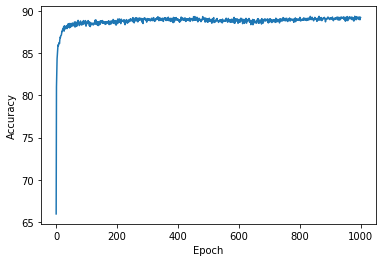

In [7]:
pyplot.plot(np.full((len(history.history['val_mape']),), 100)-history.history['val_mape'])
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.show()

In [8]:
mape = history.history['val_mape'][-1]
accuracy_DNN = 100-mape
print('Accuracy:', round(accuracy_DNN, 2), '%.')

Accuracy: 89.21 %.


# Compare DNN with other models

In [9]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

LASSO

In [10]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(train_x, train_y)
predictions = lasso.predict(test_x)
errors = abs(predictions - test_y)
mape = 100 * (errors / test_y)
accuracy_LASSO = 100 - np.mean(mape)
print('Accuracy:', round(accuracy_LASSO, 2), '%.')

Accuracy: 79.69 %.


Linear Regression

In [11]:
lr = linear_model.LinearRegression()
lr.fit(train_x, train_y)
predictions = lr.predict(test_x)
errors = abs(predictions - test_y)
mape = 100 * (errors / test_y)
accuracy_LR = 100 - np.mean(mape)
print('Accuracy:', round(accuracy_LR, 2), '%.')

Accuracy: 80.18 %.


Random Forest

In [12]:
lr = RandomForestRegressor(max_depth=3, random_state = 123)
lr.fit(train_x, train_y)
predictions = lr.predict(test_x)
errors = abs(predictions - test_y)
mape = 100 * (errors / test_y)
accuracy_RF = 100 - np.mean(mape)
print('Accuracy:', round(accuracy_RF, 2), '%.')

C:\Users\kevin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 81.83 %.


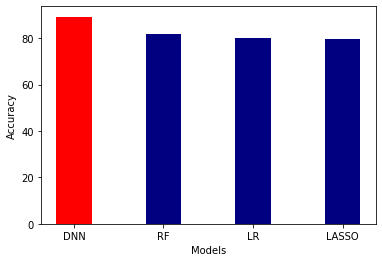

In [13]:
pyplot.bar(['DNN','RF','LR','LASSO'], [accuracy_DNN,accuracy_RF,accuracy_LR,accuracy_LASSO], width=0.4, color=['red','navy','navy','navy'])
pyplot.xlabel('Models')
pyplot.ylabel('Accuracy')
pyplot.show()

# Model Plot

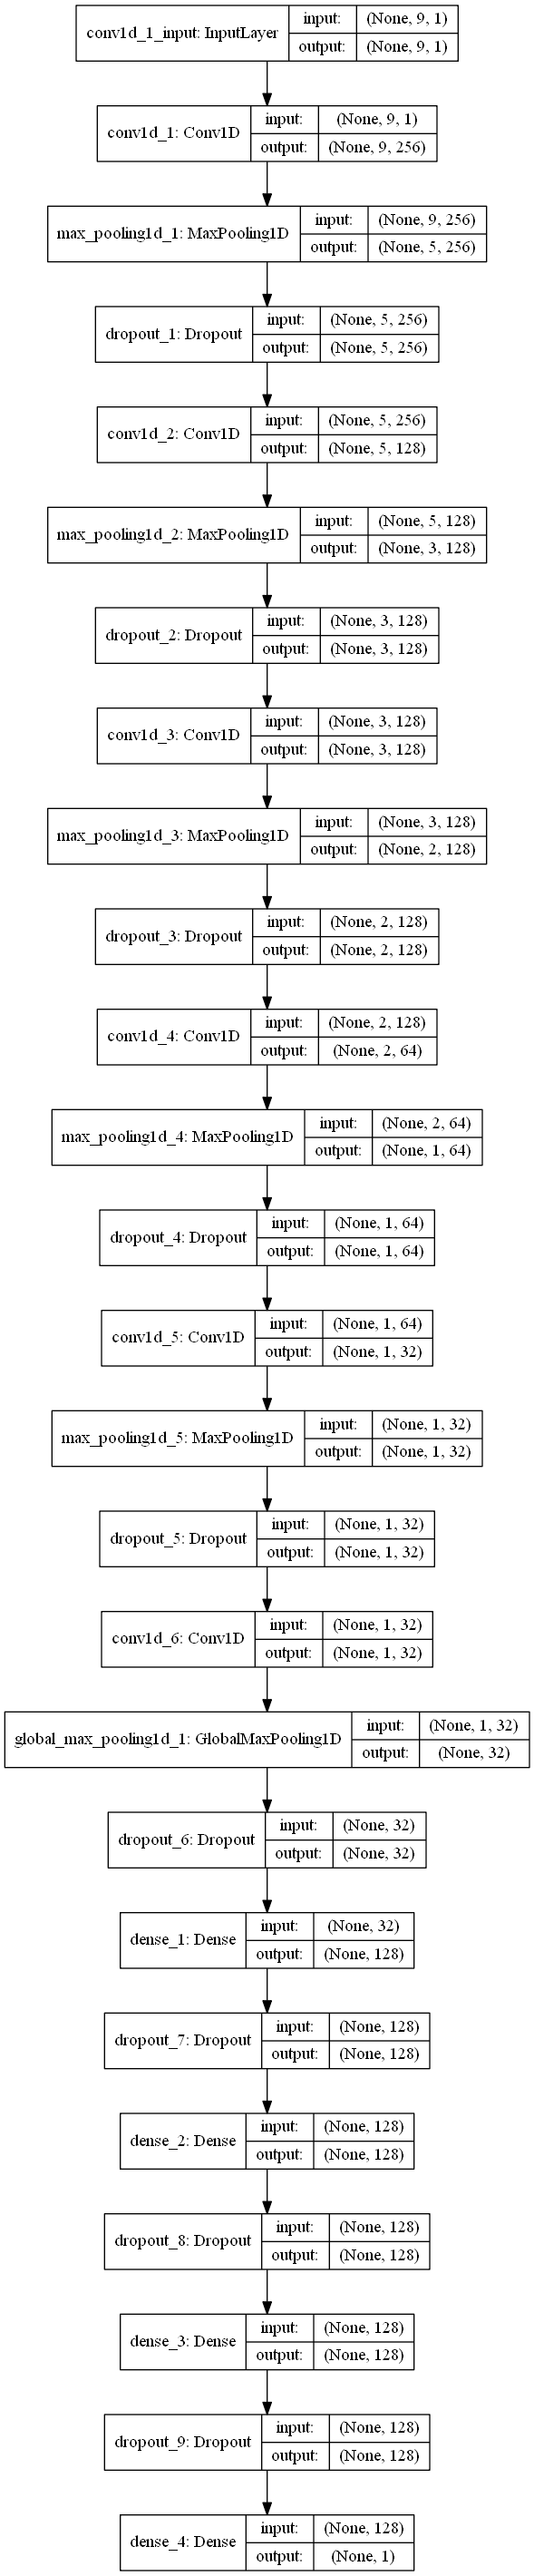

In [7]:
from keras.utils import plot_model

plot_model(
    model,
    to_file='dnn.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)